In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import (
    avg_pool2d,
    dropout,
    dropout2d,
    interpolate,
    max_pool2d,
    relu,
    sigmoid,
    tanh,
)
from torch.nn import (
    Module, Parameter, init,
    Conv2d, ConvTranspose2d, Linear, LSTM, GRU,
    BatchNorm1d, BatchNorm2d,
    PReLU
)
from cplxmodule.nn import CplxMaxPool2d


In [3]:
def apply_complex(fr, fi, input, dtype=torch.complex64):
    return (fr(input.real)-fi(input.imag)).type(dtype) \
        + 1j*(fr(input.imag)+fi(input.real)).type(dtype)

# Creates a complex noise vector of dimension (n_samples, z_dim). Every value is complex.
def get_noise(n_samples, z_dim, device='cpu'):
    real = torch.randn(n_samples, z_dim, dtype=torch.float32, device=device)
    imag = torch.randn(n_samples, z_dim, dtype=torch.float32, device=device)
    return torch.complex(real, imag)
    
def complex_relu(inp):
    return relu(inp.real).type(torch.complex64) + 1j * relu(inp.imag).type(torch.complex64)


def complex_sigmoid(inp):
    return sigmoid(inp.real).type(torch.complex64) + 1j * sigmoid(inp.imag).type(torch.complex64)


def complex_tanh(inp):
    return tanh(inp.real).type(torch.complex64) + 1j * tanh(inp.imag).type(
        torch.complex64
    )

class ComplexReLU(Module):
    @staticmethod
    def forward(inp):
        return complex_relu(inp)

class ComplexTanh(Module):
    @staticmethod
    def forward(inp):
        return complex_tanh(inp)


class ComplexSigmoid(Module):
    @staticmethod
    def forward(inp):
        return complex_sigmoid(inp)
      

class ComplexPReLU(Module):
    def __init__(self):
        super().__init__()
        self.r_prelu = PReLU()        
        self.i_prelu = PReLU()

    @staticmethod
    def forward(self, inp):
        return self.r_prelu(inp.real) + 1j*self.i_prelu(inp.imag)

class ComplexLinear(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc_r = Linear(in_features, out_features) # Linear layer for the real part
        self.fc_i = Linear(in_features, out_features) # Linear Layer for the imaginary part

    def forward(self, inp):
        return apply_complex(self.fc_r, self.fc_i, inp)


class TwoChannelsToComplex(nn.Module):
    def __init__(self):
        super(TwoChannelsToComplex, self).__init__()

    def forward(self, x):
        real, imag = torch.chunk(x, 2, dim=1)
        complex_tensor = torch.complex(real.squeeze(1), imag.squeeze(1))
        return complex_tensor
class ComplexToTwoChannels(nn.Module):
    def __init__(self):
        super(ComplexToTwoChannels, self).__init__()

    def forward(self, x):
        real = x.real.unsqueeze(1)
        imag = x.imag.unsqueeze(1)
        two_channel_tensor = torch.cat((real, imag), dim=1)
        return two_channel_tensor

class InverseFourierTransform2D(nn.Module):
    def __init__(self, norm='ortho'):
        super(InverseFourierTransform2D, self).__init__()
        self.norm = norm

    def forward(self, x):
        return torch.fft.ifft2(x, norm=self.norm)


# class FourierConv2d(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size):
#         super(FourierConv2d, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = kernel_size

#         # Initialize complex-valued filters
#         self.real_filter = nn.Parameter(torch.empty(1,out_channels, in_channels, kernel_size, kernel_size))
#         self.imag_filter = nn.Parameter(torch.empty(1,out_channels, in_channels, kernel_size, kernel_size))
#         self.reset_parameters()
    
#     def reset_parameters(self):
#         # Initialize filter weights
#         nn.init.kaiming_uniform_(self.real_filter, a=0, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_uniform_(self.imag_filter, a=0, mode='fan_in', nonlinearity='relu')

#     def forward(self, x):
#         # Combine real and imaginary parts to create complex-valued filters
#         print(x.shape)
#         print("real_filter shape_", self.real_filter.shape)
#         complex_filter = torch.complex(self.real_filter, self.imag_filter)
#         print("Filter shape: ",complex_filter.shape)

#         # Perform complex elementwise multiplication
#         output = x * complex_filter

#         return output
    
class FourierConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(FourierConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # Initialize real and imaginary parts of the filters
        self.real_weights = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.imag_weights = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))

    def forward(self, x):
        # Combine real and imaginary parts of the filters
        complex_weights = torch.complex(self.real_weights, self.imag_weights)

        # Perform complex elementwise multiplication
        output = x.unsqueeze(1) * complex_weights

        # Sum over the input channels
        output = output.sum(dim=2)

        return output
    

class ComplexMaxPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False):
        super(ComplexMaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride or kernel_size
        self.padding = padding
        self.dilation = dilation
        self.return_indices = return_indices
        self.ceil_mode = ceil_mode

    def forward(self, x):
        # Compute the absolute values of the complex numbers
        abs_values = torch.abs(x)

        # Apply max pooling on the absolute values
        _, indices = nn.functional.max_pool2d(
            abs_values,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            ceil_mode=self.ceil_mode,
            return_indices=True
        )

        # Use the indices to select the corresponding complex numbers
        output = torch.gather(x, dim=2, index=indices.unsqueeze(2).expand(-1, -1, x.size(2), -1))
        output = torch.gather(output, dim=3, index=indices.unsqueeze(3).expand(-1, -1, -1, x.size(3)))

        if self.return_indices:
            return output, indices
        else:
            return output.squeeze()

#  Download the Fashion MNIST dataset

In [4]:


transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:03<00:00, 7639334.55it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 2419380.91it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 7369521.07it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8558175.58it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



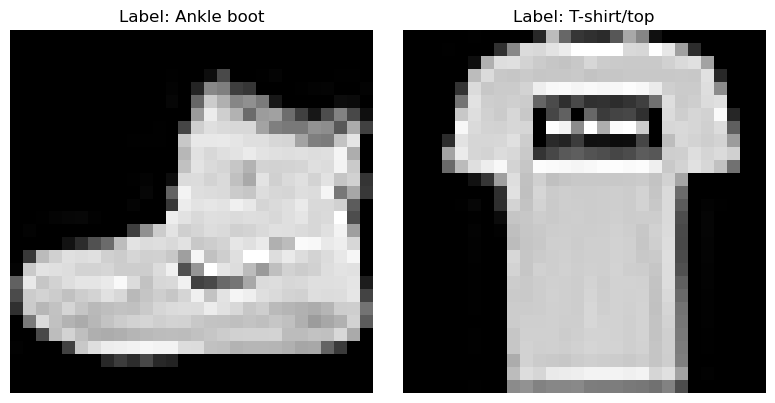

In [5]:

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    image, label = train_data[i]
    ax[i].imshow(image.squeeze(), cmap='gray')
    ax[i].set_title(f"Label: {train_data.classes[label]}")
    ax[i].axis('off')
plt.tight_layout()
plt.show()


# Perform the Fourier Transform on all data

In [6]:

def fft_transform(data):
    fft_data = []
    for img, _ in data:
        fft = np.fft.fft2(img.numpy().squeeze())
        fft_data.append(fft)
    return np.array(fft_data)

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)





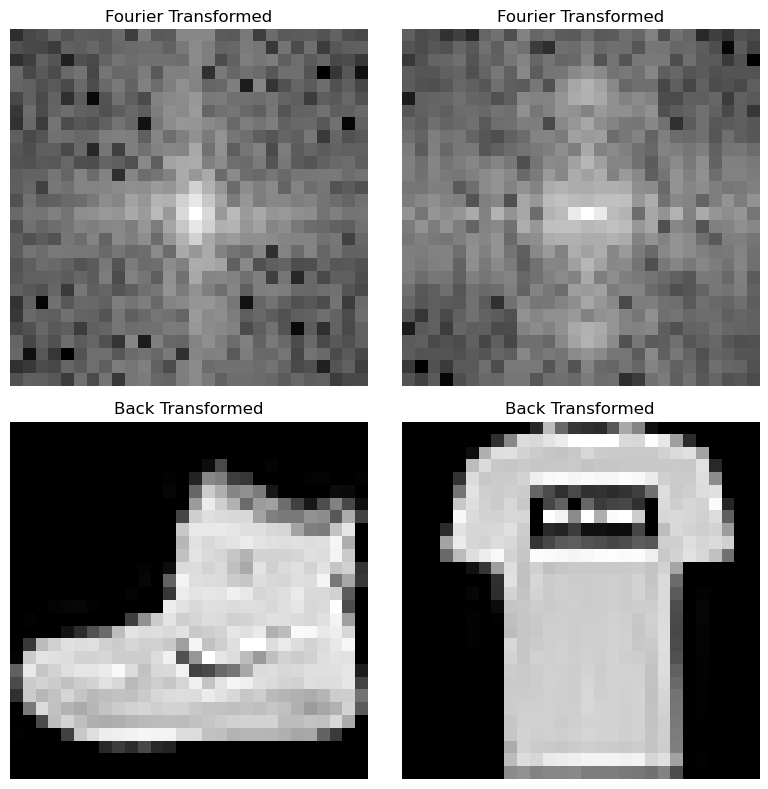

In [7]:
# 4. Plot Fourier transformed and back-transformed examples
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    ax[0, i].imshow(np.log(np.abs(np.fft.fftshift(train_fft[i]))), cmap='gray')
    ax[0, i].set_title("Fourier Transformed")
    ax[0, i].axis('off')
    
    back_transformed = np.fft.ifft2(train_fft[i]).real
    ax[1, i].imshow(back_transformed, cmap='gray')
    ax[1, i].set_title("Back Transformed")
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()

# Create dataset

In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random

class ComplexDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        real_data = torch.from_numpy(sample.real).float()
        imag_data = torch.from_numpy(sample.imag).float()
        complex_data = torch.stack((real_data, imag_data), dim=0)

        if self.transform:
            complex_data = self.transform(complex_data)

        return complex_data, label


class RandomPixelMask(object):
    """
     A augmentation technique to set datapoints in a 2D matrix to 0. It sets a fraction between 0 and max_fraction to 0. Intended to work in the frequency domain
    """

    def __init__(self, max_fraction=0.25):
        self.max_fraction = max_fraction

    def __call__(self, sample):
        # Assuming sample is a 2-channel tensor of shape (2, 28, 28)
        fraction = random.uniform(0, self.max_fraction)
        mask = torch.rand(1, 28, 28) < fraction
        mask = mask.repeat(2, 1, 1)  # Repeat the mask for both channels
        sample[mask] = 0.0
        return sample

transform = transforms.Compose([RandomPixelMask()])
# Create the custom dataset
train_labels = [label for _, label in train_data]
train_dataset = ComplexDataset(train_fft, train_labels, transform=None) 

test_labels = [label for _, label in test_data]
test_dataset = ComplexDataset(test_fft, test_labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

938


torch.Size([2, 28, 28])
tensor(144.7020) tensor(51.3852) tensor(-106.3839) tensor(-51.3852) tensor(144.7020) tensor(0.1170)


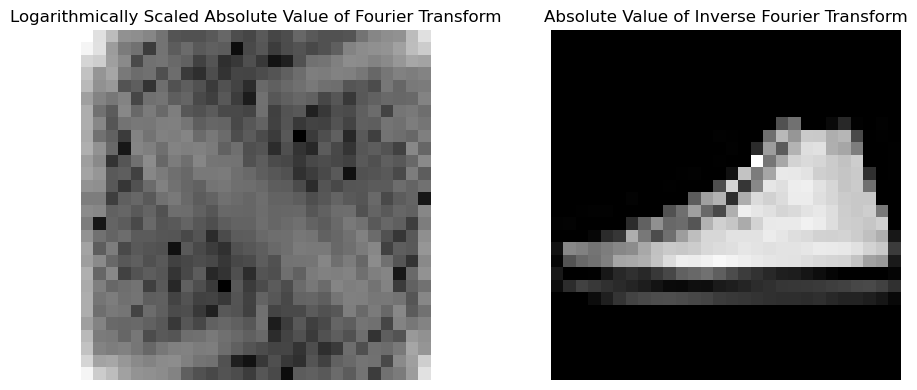

In [9]:
# Load one sample from the test loader
test_sample, test_label = next(iter(train_loader))

# Get the first sample from the batch
test_sample = test_sample[14]
print(test_sample.shape)
test_sample = torch.complex(test_sample[0], test_sample[1])
print(test_sample.real.max(),test_sample.imag.max(), test_sample.real.min(), test_sample.imag.min(),np.abs(test_sample).max(),np.abs(test_sample).min())
# Compute the absolute value and apply logarithmic scaling
abs_fft = torch.abs(test_sample)
log_abs_fft = torch.log(abs_fft + 1e-7)  # Add a small constant to avoid taking log of zero

# Compute the inverse Fourier transform
ifft_sample = torch.fft.ifft2(test_sample)
ifft_abs = torch.abs(ifft_sample)

# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the logarithmically scaled absolute value of the Fourier transform
ax1.imshow(log_abs_fft.squeeze(), cmap='gray')
ax1.set_title("Logarithmically Scaled Absolute Value of Fourier Transform")
ax1.axis('off')

# Plot the absolute value of the inverse Fourier transform
ax2.imshow(ifft_abs.squeeze(), cmap='gray')
ax2.set_title("Absolute Value of Inverse Fourier Transform")
ax2.axis('off')

plt.tight_layout()
plt.show()

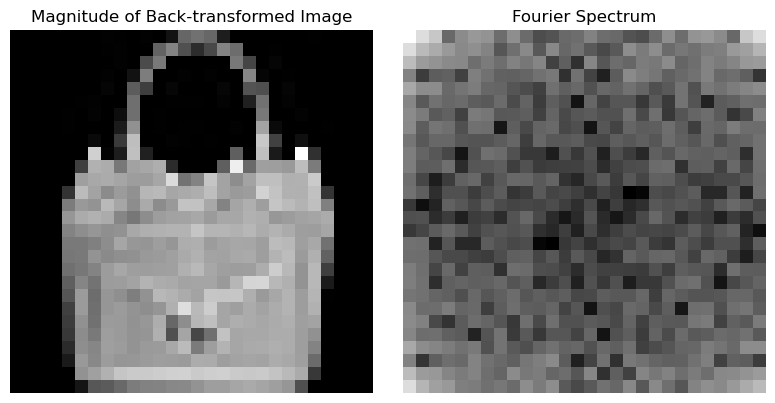

In [10]:
# Assuming you have imported the necessary libraries and defined the layers

# Get one batch from the train_loader
for batch_data, batch_labels in train_loader:
    # Take the first image from the batch
    image = batch_data[0]
    break

# Create instances of the layers
to_complex = TwoChannelsToComplex()
ifft_layer = InverseFourierTransform2D(norm='ortho')
to_two_channels = ComplexToTwoChannels()

# Apply the layers to the image
complex_image = to_complex(image.unsqueeze(0))  # Add batch dimension
back_transformed_complex = ifft_layer(complex_image)
back_transformed_two_channels = to_two_channels(back_transformed_complex)

# Calculate the magnitude of the back-transformed image
magnitude = torch.sqrt(back_transformed_two_channels[:, 0]**2 + back_transformed_two_channels[:, 1]**2)

# Calculate the magnitude of the Fourier spectrum
fourier_spectrum = torch.sqrt(complex_image.real**2 + complex_image.imag**2)

# Display the magnitude image and Fourier spectrum
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(magnitude[0].squeeze(), cmap='gray')
plt.title('Magnitude of Back-transformed Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.log(fourier_spectrum[0]).squeeze(), cmap='gray')
plt.title('Fourier Spectrum')
plt.axis('off')

plt.tight_layout()
plt.show()

# Network Structures

In [11]:
# test
class FourierCNN(nn.Module):
    def __init__(self):
        super(FourierCNN, self).__init__()
        self.channeltocomplex = TwoChannelsToComplex()
        self.complextochannel = ComplexToTwoChannels()
        self.ifft = InverseFourierTransform2D(norm='ortho')
        self.conv1 = FourierConv2d(in_channels=1, out_channels=16, kernel_size=28)
        self.maxpool1 = CplxMaxPool2d(kernel_size=2)
        self.conv2 = FourierConv2d(in_channels=16, out_channels=32, kernel_size=14) # Decreasing kernel sizes since we Pool
        self.conv3 = FourierConv2d(in_channels=32, out_channels=64, kernel_size=7)
        self.dropout0 = nn.Dropout2d(0.35)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(6272, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        # print(x.shape)
        x= self.channeltocomplex(x)
        x=x.unsqueeze(1)
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = ComplexReLU()(x)
        x = self.conv2(x)
        x = ComplexReLU()(x)
        x = self.conv3(x)
        x = ComplexReLU()(x)
        #x = self.dropout1(x)
        x = self.complextochannel(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.dropout0(x)
        x = self.fc3(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.fc4(x)
        return nn.functional.log_softmax(x, dim=1)

model = FourierCNN()

# Train Loop

In [65]:
from tqdm import tqdm
# 7. Train the network on the Fourier transformed data
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        progress_bar.set_postfix({"Train Loss": train_loss / (batch_idx + 1), "Train Acc": 100. * correct / total})
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy


## Start training

In [66]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 500

for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)
    
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print()

Epoch 1:   0%|          | 0/938 [00:00<?, ?batch/s]/home/marco/miniconda3/envs/pytorch-env/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 1:   0%|          | 0/938 [00:00<?, ?batch/s, Train Loss=128, Train Acc=6.25]

Epoch 1: 100%|██████████| 938/938 [00:04<00:00, 210.14batch/s, Train Loss=10.6, Train Acc=40.9]


Epoch 1
Train Loss: 10.6394, Train Accuracy: 40.91%
Test Loss: 0.8263, Test Accuracy: 73.07%



Epoch 2: 100%|██████████| 938/938 [00:04<00:00, 212.87batch/s, Train Loss=1.5, Train Acc=57.4] 


Epoch 2
Train Loss: 1.4993, Train Accuracy: 57.45%
Test Loss: 0.7539, Test Accuracy: 75.44%



Epoch 3: 100%|██████████| 938/938 [00:04<00:00, 209.57batch/s, Train Loss=1.12, Train Acc=64.4]


Epoch 3
Train Loss: 1.1175, Train Accuracy: 64.44%
Test Loss: 0.6720, Test Accuracy: 77.77%



Epoch 4: 100%|██████████| 938/938 [00:04<00:00, 213.71batch/s, Train Loss=0.945, Train Acc=69.2]


Epoch 4
Train Loss: 0.9445, Train Accuracy: 69.21%
Test Loss: 0.6072, Test Accuracy: 79.26%



Epoch 5: 100%|██████████| 938/938 [00:04<00:00, 212.83batch/s, Train Loss=0.838, Train Acc=72.5]


Epoch 5
Train Loss: 0.8377, Train Accuracy: 72.54%
Test Loss: 0.5686, Test Accuracy: 80.89%



Epoch 6: 100%|██████████| 938/938 [00:04<00:00, 208.65batch/s, Train Loss=0.758, Train Acc=74.8]


Epoch 6
Train Loss: 0.7580, Train Accuracy: 74.81%
Test Loss: 0.5396, Test Accuracy: 82.04%



Epoch 7: 100%|██████████| 938/938 [00:04<00:00, 212.12batch/s, Train Loss=0.7, Train Acc=76.8]  


Epoch 7
Train Loss: 0.7002, Train Accuracy: 76.84%
Test Loss: 0.5139, Test Accuracy: 82.31%



Epoch 8: 100%|██████████| 938/938 [00:04<00:00, 215.29batch/s, Train Loss=0.657, Train Acc=77.9]


Epoch 8
Train Loss: 0.6572, Train Accuracy: 77.91%
Test Loss: 0.5041, Test Accuracy: 82.95%



Epoch 9: 100%|██████████| 938/938 [00:04<00:00, 213.68batch/s, Train Loss=0.619, Train Acc=79.1]


Epoch 9
Train Loss: 0.6194, Train Accuracy: 79.14%
Test Loss: 0.4827, Test Accuracy: 83.20%



Epoch 10: 100%|██████████| 938/938 [00:04<00:00, 213.25batch/s, Train Loss=0.586, Train Acc=80]  


Epoch 10
Train Loss: 0.5858, Train Accuracy: 80.03%
Test Loss: 0.4785, Test Accuracy: 83.54%



Epoch 11: 100%|██████████| 938/938 [00:04<00:00, 213.82batch/s, Train Loss=0.562, Train Acc=80.9]


Epoch 11
Train Loss: 0.5620, Train Accuracy: 80.89%
Test Loss: 0.4554, Test Accuracy: 83.99%



Epoch 12: 100%|██████████| 938/938 [00:04<00:00, 206.97batch/s, Train Loss=0.533, Train Acc=81.6]


Epoch 12
Train Loss: 0.5332, Train Accuracy: 81.58%
Test Loss: 0.4556, Test Accuracy: 84.29%



Epoch 13: 100%|██████████| 938/938 [00:04<00:00, 203.18batch/s, Train Loss=0.515, Train Acc=82.3]


Epoch 13
Train Loss: 0.5149, Train Accuracy: 82.27%
Test Loss: 0.4438, Test Accuracy: 84.27%



Epoch 14: 100%|██████████| 938/938 [00:04<00:00, 203.42batch/s, Train Loss=0.496, Train Acc=82.9]


Epoch 14
Train Loss: 0.4959, Train Accuracy: 82.89%
Test Loss: 0.4304, Test Accuracy: 84.79%



Epoch 15: 100%|██████████| 938/938 [00:04<00:00, 201.89batch/s, Train Loss=0.479, Train Acc=83.4]


Epoch 15
Train Loss: 0.4791, Train Accuracy: 83.44%
Test Loss: 0.4256, Test Accuracy: 84.83%



Epoch 16: 100%|██████████| 938/938 [00:04<00:00, 217.61batch/s, Train Loss=0.462, Train Acc=83.8]


Epoch 16
Train Loss: 0.4623, Train Accuracy: 83.85%
Test Loss: 0.4317, Test Accuracy: 84.85%



Epoch 17: 100%|██████████| 938/938 [00:04<00:00, 216.29batch/s, Train Loss=0.45, Train Acc=84.3] 


Epoch 17
Train Loss: 0.4499, Train Accuracy: 84.33%
Test Loss: 0.4173, Test Accuracy: 85.01%



Epoch 18: 100%|██████████| 938/938 [00:04<00:00, 215.95batch/s, Train Loss=0.438, Train Acc=84.6]


Epoch 18
Train Loss: 0.4383, Train Accuracy: 84.57%
Test Loss: 0.4147, Test Accuracy: 84.80%



Epoch 19: 100%|██████████| 938/938 [00:04<00:00, 215.54batch/s, Train Loss=0.425, Train Acc=84.8]


Epoch 19
Train Loss: 0.4253, Train Accuracy: 84.78%
Test Loss: 0.4118, Test Accuracy: 85.30%



Epoch 20: 100%|██████████| 938/938 [00:04<00:00, 218.66batch/s, Train Loss=0.416, Train Acc=85.2]


Epoch 20
Train Loss: 0.4159, Train Accuracy: 85.22%
Test Loss: 0.4080, Test Accuracy: 85.33%



Epoch 21: 100%|██████████| 938/938 [00:04<00:00, 215.62batch/s, Train Loss=0.406, Train Acc=85.5]


Epoch 21
Train Loss: 0.4059, Train Accuracy: 85.47%
Test Loss: 0.4102, Test Accuracy: 85.63%



Epoch 22: 100%|██████████| 938/938 [00:04<00:00, 215.75batch/s, Train Loss=0.393, Train Acc=85.9]


Epoch 22
Train Loss: 0.3929, Train Accuracy: 85.95%
Test Loss: 0.4037, Test Accuracy: 85.41%



Epoch 23: 100%|██████████| 938/938 [00:04<00:00, 210.65batch/s, Train Loss=0.388, Train Acc=86.2]


Epoch 23
Train Loss: 0.3880, Train Accuracy: 86.20%
Test Loss: 0.4040, Test Accuracy: 85.72%



Epoch 24: 100%|██████████| 938/938 [00:04<00:00, 201.05batch/s, Train Loss=0.375, Train Acc=86.6]


Epoch 24
Train Loss: 0.3746, Train Accuracy: 86.56%
Test Loss: 0.3969, Test Accuracy: 85.83%



Epoch 25: 100%|██████████| 938/938 [00:04<00:00, 202.35batch/s, Train Loss=0.368, Train Acc=86.7]


Epoch 25
Train Loss: 0.3681, Train Accuracy: 86.66%
Test Loss: 0.3989, Test Accuracy: 85.90%



Epoch 26: 100%|██████████| 938/938 [00:04<00:00, 207.55batch/s, Train Loss=0.358, Train Acc=87.1]


Epoch 26
Train Loss: 0.3576, Train Accuracy: 87.06%
Test Loss: 0.3944, Test Accuracy: 85.86%



Epoch 27: 100%|██████████| 938/938 [00:04<00:00, 209.52batch/s, Train Loss=0.348, Train Acc=87.3]


Epoch 27
Train Loss: 0.3475, Train Accuracy: 87.32%
Test Loss: 0.3947, Test Accuracy: 85.96%



Epoch 28: 100%|██████████| 938/938 [00:04<00:00, 207.36batch/s, Train Loss=0.341, Train Acc=87.6]


Epoch 28
Train Loss: 0.3406, Train Accuracy: 87.57%
Test Loss: 0.4029, Test Accuracy: 85.82%



Epoch 29: 100%|██████████| 938/938 [00:04<00:00, 208.24batch/s, Train Loss=0.334, Train Acc=88]  


Epoch 29
Train Loss: 0.3339, Train Accuracy: 87.95%
Test Loss: 0.4007, Test Accuracy: 85.92%



Epoch 30: 100%|██████████| 938/938 [00:04<00:00, 208.40batch/s, Train Loss=0.326, Train Acc=88.1]


Epoch 30
Train Loss: 0.3261, Train Accuracy: 88.06%
Test Loss: 0.3954, Test Accuracy: 85.98%



Epoch 31: 100%|██████████| 938/938 [00:04<00:00, 213.72batch/s, Train Loss=0.32, Train Acc=88.3] 


Epoch 31
Train Loss: 0.3198, Train Accuracy: 88.28%
Test Loss: 0.3936, Test Accuracy: 85.99%



Epoch 32: 100%|██████████| 938/938 [00:04<00:00, 218.51batch/s, Train Loss=0.315, Train Acc=88.5]


Epoch 32
Train Loss: 0.3151, Train Accuracy: 88.53%
Test Loss: 0.3964, Test Accuracy: 86.19%



Epoch 33: 100%|██████████| 938/938 [00:04<00:00, 220.00batch/s, Train Loss=0.308, Train Acc=88.6]


Epoch 33
Train Loss: 0.3080, Train Accuracy: 88.65%
Test Loss: 0.3968, Test Accuracy: 85.89%



Epoch 34: 100%|██████████| 938/938 [00:04<00:00, 220.16batch/s, Train Loss=0.3, Train Acc=89]    


Epoch 34
Train Loss: 0.2997, Train Accuracy: 88.98%
Test Loss: 0.3923, Test Accuracy: 86.09%



Epoch 35: 100%|██████████| 938/938 [00:04<00:00, 214.75batch/s, Train Loss=0.295, Train Acc=89.2]


Epoch 35
Train Loss: 0.2946, Train Accuracy: 89.24%
Test Loss: 0.4029, Test Accuracy: 86.10%



Epoch 36: 100%|██████████| 938/938 [00:04<00:00, 209.63batch/s, Train Loss=0.294, Train Acc=89.3]


Epoch 36
Train Loss: 0.2937, Train Accuracy: 89.27%
Test Loss: 0.3975, Test Accuracy: 86.23%



Epoch 37: 100%|██████████| 938/938 [00:04<00:00, 212.06batch/s, Train Loss=0.285, Train Acc=89.5]


Epoch 37
Train Loss: 0.2852, Train Accuracy: 89.45%
Test Loss: 0.3982, Test Accuracy: 86.10%



Epoch 38: 100%|██████████| 938/938 [00:04<00:00, 215.59batch/s, Train Loss=0.276, Train Acc=89.7]


Epoch 38
Train Loss: 0.2757, Train Accuracy: 89.73%
Test Loss: 0.4127, Test Accuracy: 86.08%



Epoch 39: 100%|██████████| 938/938 [00:04<00:00, 208.97batch/s, Train Loss=0.274, Train Acc=89.8]


Epoch 39
Train Loss: 0.2739, Train Accuracy: 89.79%
Test Loss: 0.3968, Test Accuracy: 86.23%



Epoch 40: 100%|██████████| 938/938 [00:04<00:00, 212.60batch/s, Train Loss=0.265, Train Acc=90.2]


Epoch 40
Train Loss: 0.2650, Train Accuracy: 90.17%
Test Loss: 0.4083, Test Accuracy: 86.08%



Epoch 41: 100%|██████████| 938/938 [00:04<00:00, 214.91batch/s, Train Loss=0.265, Train Acc=90]  


Epoch 41
Train Loss: 0.2646, Train Accuracy: 90.05%
Test Loss: 0.4093, Test Accuracy: 86.14%



Epoch 42: 100%|██████████| 938/938 [00:04<00:00, 217.73batch/s, Train Loss=0.257, Train Acc=90.4]


Epoch 42
Train Loss: 0.2571, Train Accuracy: 90.36%
Test Loss: 0.4073, Test Accuracy: 86.52%



Epoch 43: 100%|██████████| 938/938 [00:04<00:00, 217.37batch/s, Train Loss=0.254, Train Acc=90.4]


Epoch 43
Train Loss: 0.2544, Train Accuracy: 90.38%
Test Loss: 0.4076, Test Accuracy: 86.41%



Epoch 44: 100%|██████████| 938/938 [00:04<00:00, 218.06batch/s, Train Loss=0.25, Train Acc=90.7] 


Epoch 44
Train Loss: 0.2495, Train Accuracy: 90.72%
Test Loss: 0.4072, Test Accuracy: 86.30%



Epoch 45: 100%|██████████| 938/938 [00:04<00:00, 215.42batch/s, Train Loss=0.247, Train Acc=90.7]


Epoch 45
Train Loss: 0.2466, Train Accuracy: 90.67%
Test Loss: 0.4089, Test Accuracy: 86.61%



Epoch 46: 100%|██████████| 938/938 [00:04<00:00, 209.25batch/s, Train Loss=0.241, Train Acc=90.8]


Epoch 46
Train Loss: 0.2415, Train Accuracy: 90.81%
Test Loss: 0.4248, Test Accuracy: 86.16%



Epoch 47: 100%|██████████| 938/938 [00:04<00:00, 207.50batch/s, Train Loss=0.238, Train Acc=91.1]


Epoch 47
Train Loss: 0.2378, Train Accuracy: 91.07%
Test Loss: 0.4209, Test Accuracy: 86.59%



Epoch 48: 100%|██████████| 938/938 [00:04<00:00, 211.10batch/s, Train Loss=0.232, Train Acc=91.2]


Epoch 48
Train Loss: 0.2324, Train Accuracy: 91.25%
Test Loss: 0.4107, Test Accuracy: 86.37%



Epoch 49: 100%|██████████| 938/938 [00:04<00:00, 210.60batch/s, Train Loss=0.229, Train Acc=91.3]


Epoch 49
Train Loss: 0.2286, Train Accuracy: 91.34%
Test Loss: 0.4256, Test Accuracy: 86.51%



Epoch 50: 100%|██████████| 938/938 [00:04<00:00, 207.46batch/s, Train Loss=0.227, Train Acc=91.4]


Epoch 50
Train Loss: 0.2265, Train Accuracy: 91.39%
Test Loss: 0.4157, Test Accuracy: 86.64%



Epoch 51: 100%|██████████| 938/938 [00:04<00:00, 208.29batch/s, Train Loss=0.218, Train Acc=91.7]


Epoch 51
Train Loss: 0.2182, Train Accuracy: 91.68%
Test Loss: 0.4250, Test Accuracy: 86.52%



Epoch 52: 100%|██████████| 938/938 [00:04<00:00, 208.05batch/s, Train Loss=0.217, Train Acc=91.8]


Epoch 52
Train Loss: 0.2170, Train Accuracy: 91.79%
Test Loss: 0.4285, Test Accuracy: 86.75%



Epoch 53: 100%|██████████| 938/938 [00:04<00:00, 219.34batch/s, Train Loss=0.211, Train Acc=91.9]


Epoch 53
Train Loss: 0.2110, Train Accuracy: 91.89%
Test Loss: 0.4271, Test Accuracy: 86.26%



Epoch 54: 100%|██████████| 938/938 [00:04<00:00, 216.24batch/s, Train Loss=0.208, Train Acc=92]  


Epoch 54
Train Loss: 0.2077, Train Accuracy: 92.02%
Test Loss: 0.4466, Test Accuracy: 86.71%



Epoch 55: 100%|██████████| 938/938 [00:04<00:00, 218.01batch/s, Train Loss=0.206, Train Acc=92]  


Epoch 55
Train Loss: 0.2058, Train Accuracy: 92.02%
Test Loss: 0.4402, Test Accuracy: 86.36%



Epoch 56: 100%|██████████| 938/938 [00:04<00:00, 216.80batch/s, Train Loss=0.202, Train Acc=92.2]


Epoch 56
Train Loss: 0.2016, Train Accuracy: 92.19%
Test Loss: 0.4444, Test Accuracy: 86.44%



Epoch 57: 100%|██████████| 938/938 [00:04<00:00, 213.76batch/s, Train Loss=0.201, Train Acc=92.2]


Epoch 57
Train Loss: 0.2006, Train Accuracy: 92.22%
Test Loss: 0.4415, Test Accuracy: 86.73%



Epoch 58: 100%|██████████| 938/938 [00:04<00:00, 206.16batch/s, Train Loss=0.197, Train Acc=92.4]


Epoch 58
Train Loss: 0.1969, Train Accuracy: 92.43%
Test Loss: 0.4418, Test Accuracy: 86.53%



Epoch 59: 100%|██████████| 938/938 [00:04<00:00, 208.22batch/s, Train Loss=0.188, Train Acc=92.8]


Epoch 59
Train Loss: 0.1881, Train Accuracy: 92.75%
Test Loss: 0.4417, Test Accuracy: 86.45%



Epoch 60: 100%|██████████| 938/938 [00:04<00:00, 210.30batch/s, Train Loss=0.19, Train Acc=92.6] 


Epoch 60
Train Loss: 0.1900, Train Accuracy: 92.64%
Test Loss: 0.4572, Test Accuracy: 86.65%



Epoch 61: 100%|██████████| 938/938 [00:04<00:00, 205.86batch/s, Train Loss=0.188, Train Acc=92.7]


Epoch 61
Train Loss: 0.1881, Train Accuracy: 92.67%
Test Loss: 0.4704, Test Accuracy: 86.57%



Epoch 62: 100%|██████████| 938/938 [00:04<00:00, 217.20batch/s, Train Loss=0.185, Train Acc=92.9]


Epoch 62
Train Loss: 0.1848, Train Accuracy: 92.89%
Test Loss: 0.4688, Test Accuracy: 86.82%



Epoch 63: 100%|██████████| 938/938 [00:04<00:00, 217.49batch/s, Train Loss=0.18, Train Acc=93.1] 


Epoch 63
Train Loss: 0.1798, Train Accuracy: 93.06%
Test Loss: 0.4629, Test Accuracy: 86.61%



Epoch 64: 100%|██████████| 938/938 [00:04<00:00, 214.92batch/s, Train Loss=0.178, Train Acc=93.2]


Epoch 64
Train Loss: 0.1776, Train Accuracy: 93.16%
Test Loss: 0.4946, Test Accuracy: 86.56%



Epoch 65: 100%|██████████| 938/938 [00:04<00:00, 215.73batch/s, Train Loss=0.179, Train Acc=93.1]


Epoch 65
Train Loss: 0.1794, Train Accuracy: 93.11%
Test Loss: 0.4546, Test Accuracy: 86.44%



Epoch 66: 100%|██████████| 938/938 [00:04<00:00, 216.17batch/s, Train Loss=0.172, Train Acc=93.3]


Epoch 66
Train Loss: 0.1715, Train Accuracy: 93.31%
Test Loss: 0.4858, Test Accuracy: 86.42%



Epoch 67: 100%|██████████| 938/938 [00:04<00:00, 212.07batch/s, Train Loss=0.17, Train Acc=93.3] 


Epoch 67
Train Loss: 0.1699, Train Accuracy: 93.33%
Test Loss: 0.5060, Test Accuracy: 86.42%



Epoch 68: 100%|██████████| 938/938 [00:04<00:00, 210.85batch/s, Train Loss=0.17, Train Acc=93.6] 


Epoch 68
Train Loss: 0.1703, Train Accuracy: 93.57%
Test Loss: 0.4864, Test Accuracy: 86.66%



Epoch 69: 100%|██████████| 938/938 [00:04<00:00, 215.91batch/s, Train Loss=0.164, Train Acc=93.6]


Epoch 69
Train Loss: 0.1641, Train Accuracy: 93.55%
Test Loss: 0.4742, Test Accuracy: 86.63%



Epoch 70: 100%|██████████| 938/938 [00:04<00:00, 204.77batch/s, Train Loss=0.167, Train Acc=93.5]


Epoch 70
Train Loss: 0.1667, Train Accuracy: 93.55%
Test Loss: 0.4939, Test Accuracy: 86.32%



Epoch 71: 100%|██████████| 938/938 [00:04<00:00, 206.71batch/s, Train Loss=0.159, Train Acc=93.8]


Epoch 71
Train Loss: 0.1594, Train Accuracy: 93.79%
Test Loss: 0.5095, Test Accuracy: 86.58%



Epoch 72: 100%|██████████| 938/938 [00:04<00:00, 205.08batch/s, Train Loss=0.163, Train Acc=93.6]


Epoch 72
Train Loss: 0.1633, Train Accuracy: 93.62%
Test Loss: 0.4921, Test Accuracy: 86.45%



Epoch 73: 100%|██████████| 938/938 [00:04<00:00, 208.85batch/s, Train Loss=0.158, Train Acc=93.9]


Epoch 73
Train Loss: 0.1580, Train Accuracy: 93.86%
Test Loss: 0.5030, Test Accuracy: 86.50%



Epoch 74: 100%|██████████| 938/938 [00:04<00:00, 218.82batch/s, Train Loss=0.153, Train Acc=94]  


Epoch 74
Train Loss: 0.1525, Train Accuracy: 93.98%
Test Loss: 0.4901, Test Accuracy: 86.94%



Epoch 75: 100%|██████████| 938/938 [00:04<00:00, 220.26batch/s, Train Loss=0.152, Train Acc=94.1]


Epoch 75
Train Loss: 0.1516, Train Accuracy: 94.05%
Test Loss: 0.5171, Test Accuracy: 86.45%



Epoch 76: 100%|██████████| 938/938 [00:04<00:00, 220.20batch/s, Train Loss=0.149, Train Acc=94.2]


Epoch 76
Train Loss: 0.1486, Train Accuracy: 94.17%
Test Loss: 0.5396, Test Accuracy: 86.43%



Epoch 77: 100%|██████████| 938/938 [00:04<00:00, 212.62batch/s, Train Loss=0.15, Train Acc=94.2] 


Epoch 77
Train Loss: 0.1499, Train Accuracy: 94.17%
Test Loss: 0.5185, Test Accuracy: 86.96%



Epoch 78: 100%|██████████| 938/938 [00:04<00:00, 202.26batch/s, Train Loss=0.148, Train Acc=94.2]


Epoch 78
Train Loss: 0.1477, Train Accuracy: 94.22%
Test Loss: 0.5140, Test Accuracy: 86.55%



Epoch 79: 100%|██████████| 938/938 [00:04<00:00, 205.87batch/s, Train Loss=0.143, Train Acc=94.5]


Epoch 79
Train Loss: 0.1432, Train Accuracy: 94.47%
Test Loss: 0.5303, Test Accuracy: 86.81%



Epoch 80: 100%|██████████| 938/938 [00:04<00:00, 211.86batch/s, Train Loss=0.145, Train Acc=94.3]


Epoch 80
Train Loss: 0.1452, Train Accuracy: 94.35%
Test Loss: 0.5485, Test Accuracy: 86.60%



Epoch 81: 100%|██████████| 938/938 [00:04<00:00, 214.48batch/s, Train Loss=0.139, Train Acc=94.5]


Epoch 81
Train Loss: 0.1395, Train Accuracy: 94.52%
Test Loss: 0.5321, Test Accuracy: 86.38%



Epoch 82: 100%|██████████| 938/938 [00:04<00:00, 210.12batch/s, Train Loss=0.141, Train Acc=94.4]


Epoch 82
Train Loss: 0.1411, Train Accuracy: 94.37%
Test Loss: 0.5326, Test Accuracy: 86.69%



Epoch 83: 100%|██████████| 938/938 [00:04<00:00, 215.94batch/s, Train Loss=0.137, Train Acc=94.6]


Epoch 83
Train Loss: 0.1369, Train Accuracy: 94.61%
Test Loss: 0.5663, Test Accuracy: 86.72%



Epoch 84: 100%|██████████| 938/938 [00:04<00:00, 206.90batch/s, Train Loss=0.139, Train Acc=94.5]


Epoch 84
Train Loss: 0.1390, Train Accuracy: 94.53%
Test Loss: 0.5628, Test Accuracy: 86.51%



Epoch 85: 100%|██████████| 938/938 [00:04<00:00, 217.29batch/s, Train Loss=0.13, Train Acc=94.9] 


Epoch 85
Train Loss: 0.1295, Train Accuracy: 94.94%
Test Loss: 0.5619, Test Accuracy: 86.68%



Epoch 86: 100%|██████████| 938/938 [00:04<00:00, 217.51batch/s, Train Loss=0.138, Train Acc=94.6]


Epoch 86
Train Loss: 0.1384, Train Accuracy: 94.56%
Test Loss: 0.5676, Test Accuracy: 86.61%



Epoch 87: 100%|██████████| 938/938 [00:04<00:00, 216.39batch/s, Train Loss=0.133, Train Acc=94.8]


Epoch 87
Train Loss: 0.1325, Train Accuracy: 94.78%
Test Loss: 0.5609, Test Accuracy: 86.71%



Epoch 88: 100%|██████████| 938/938 [00:04<00:00, 218.24batch/s, Train Loss=0.134, Train Acc=94.8]


Epoch 88
Train Loss: 0.1336, Train Accuracy: 94.77%
Test Loss: 0.5717, Test Accuracy: 86.76%



Epoch 89: 100%|██████████| 938/938 [00:04<00:00, 218.43batch/s, Train Loss=0.129, Train Acc=95]  


Epoch 89
Train Loss: 0.1289, Train Accuracy: 94.96%
Test Loss: 0.5906, Test Accuracy: 86.44%



Epoch 90: 100%|██████████| 938/938 [00:04<00:00, 209.95batch/s, Train Loss=0.127, Train Acc=95]  


Epoch 90
Train Loss: 0.1267, Train Accuracy: 95.05%
Test Loss: 0.5844, Test Accuracy: 86.65%



Epoch 91: 100%|██████████| 938/938 [00:04<00:00, 208.36batch/s, Train Loss=0.129, Train Acc=95]  


Epoch 91
Train Loss: 0.1288, Train Accuracy: 94.99%
Test Loss: 0.5654, Test Accuracy: 86.72%



Epoch 92: 100%|██████████| 938/938 [00:04<00:00, 214.35batch/s, Train Loss=0.127, Train Acc=95.1]


Epoch 92
Train Loss: 0.1274, Train Accuracy: 95.10%
Test Loss: 0.5694, Test Accuracy: 86.78%



Epoch 93: 100%|██████████| 938/938 [00:04<00:00, 215.57batch/s, Train Loss=0.121, Train Acc=95.2]


Epoch 93
Train Loss: 0.1212, Train Accuracy: 95.22%
Test Loss: 0.5808, Test Accuracy: 86.55%



Epoch 94: 100%|██████████| 938/938 [00:04<00:00, 214.45batch/s, Train Loss=0.122, Train Acc=95.3]


Epoch 94
Train Loss: 0.1216, Train Accuracy: 95.30%
Test Loss: 0.5698, Test Accuracy: 86.43%



Epoch 95: 100%|██████████| 938/938 [00:04<00:00, 207.39batch/s, Train Loss=0.124, Train Acc=95.2]


Epoch 95
Train Loss: 0.1243, Train Accuracy: 95.22%
Test Loss: 0.5837, Test Accuracy: 86.72%



Epoch 96: 100%|██████████| 938/938 [00:04<00:00, 208.60batch/s, Train Loss=0.115, Train Acc=95.5]


Epoch 96
Train Loss: 0.1153, Train Accuracy: 95.48%
Test Loss: 0.5858, Test Accuracy: 86.77%



Epoch 97: 100%|██████████| 938/938 [00:04<00:00, 214.13batch/s, Train Loss=0.122, Train Acc=95.3]


Epoch 97
Train Loss: 0.1216, Train Accuracy: 95.25%
Test Loss: 0.6236, Test Accuracy: 86.59%



Epoch 98: 100%|██████████| 938/938 [00:04<00:00, 213.99batch/s, Train Loss=0.118, Train Acc=95.4]


Epoch 98
Train Loss: 0.1185, Train Accuracy: 95.36%
Test Loss: 0.5795, Test Accuracy: 86.77%



Epoch 99: 100%|██████████| 938/938 [00:04<00:00, 213.45batch/s, Train Loss=0.117, Train Acc=95.3]


Epoch 99
Train Loss: 0.1172, Train Accuracy: 95.33%
Test Loss: 0.5960, Test Accuracy: 86.73%



Epoch 100: 100%|██████████| 938/938 [00:04<00:00, 213.33batch/s, Train Loss=0.117, Train Acc=95.3]


Epoch 100
Train Loss: 0.1174, Train Accuracy: 95.29%
Test Loss: 0.5906, Test Accuracy: 86.59%



Epoch 101: 100%|██████████| 938/938 [00:04<00:00, 210.21batch/s, Train Loss=0.113, Train Acc=95.5]


Epoch 101
Train Loss: 0.1132, Train Accuracy: 95.50%
Test Loss: 0.6282, Test Accuracy: 86.79%



Epoch 102: 100%|██████████| 938/938 [00:04<00:00, 210.80batch/s, Train Loss=0.116, Train Acc=95.5]


Epoch 102
Train Loss: 0.1161, Train Accuracy: 95.46%
Test Loss: 0.6221, Test Accuracy: 86.53%



Epoch 103:   9%|▉         | 83/938 [00:00<00:04, 213.01batch/s, Train Loss=0.11, Train Acc=95.4] 


KeyboardInterrupt: 

# Evaluation

## Prediction for a single test example

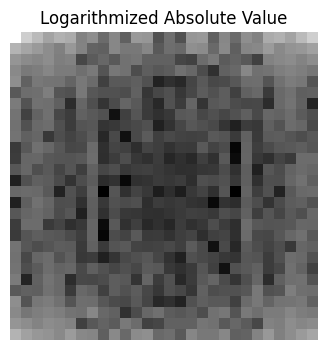

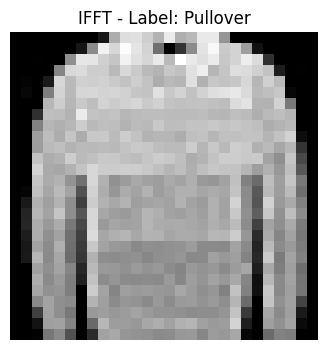

True Label: Pullover
Predicted Label: Pullover


In [56]:
example = 20
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
# Get a single test example
test_sample, test_label = next(iter(test_loader))
test_sample, test_label = test_sample[example], test_label[example]

# Make a complex number out of real and imaginary channels
complex_sample = torch.complex(test_sample[0], test_sample[1])

# Plot the absolute value logarithmized
abs_sample = torch.abs(complex_sample)
log_abs_sample = torch.log(abs_sample + 1e-7)  # Add a small constant to avoid taking log of zero

plt.figure(figsize=(4, 4))
plt.imshow(log_abs_sample.numpy(), cmap='gray')
plt.title("Logarithmized Absolute Value")
plt.axis('off')
plt.show()

# Apply the inverse Fourier transform and plot the absolute value
ifft_sample = torch.fft.ifft2(complex_sample)
ifft_abs_sample = torch.abs(ifft_sample)

plt.figure(figsize=(4, 4))
plt.imshow(ifft_abs_sample.numpy(), cmap='gray')
plt.title(f"IFFT - Label: {labels_map[test_label.item()]}")
plt.axis('off')
plt.show()

# Put the example into the trained model and predict the class
model.eval()
with torch.no_grad():
    test_sample = test_sample.unsqueeze(0).to(device)
    output = model(test_sample)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

print(f"True Label: {labels_map[test_label.item()]}")
print(f"Predicted Label: {labels_map[predicted_label]}")

## Confusion Matrix and wrong samples

/home/marco/miniconda3/envs/pytorch-env/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


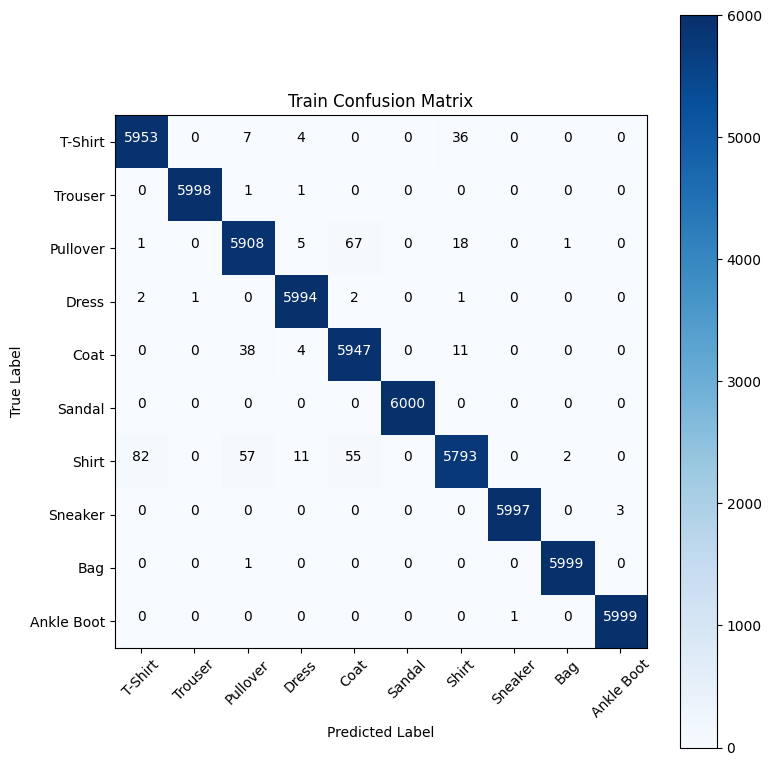

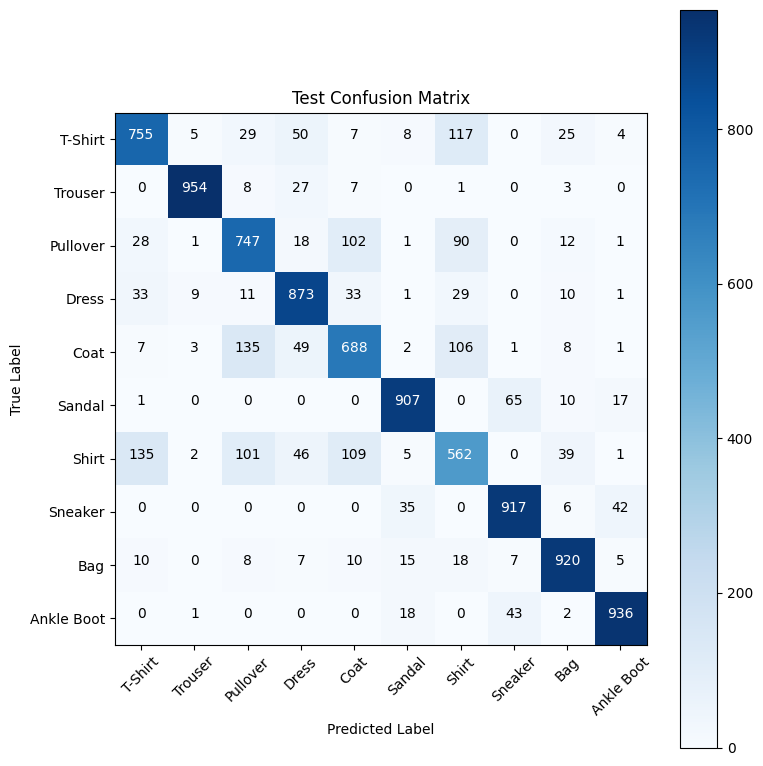

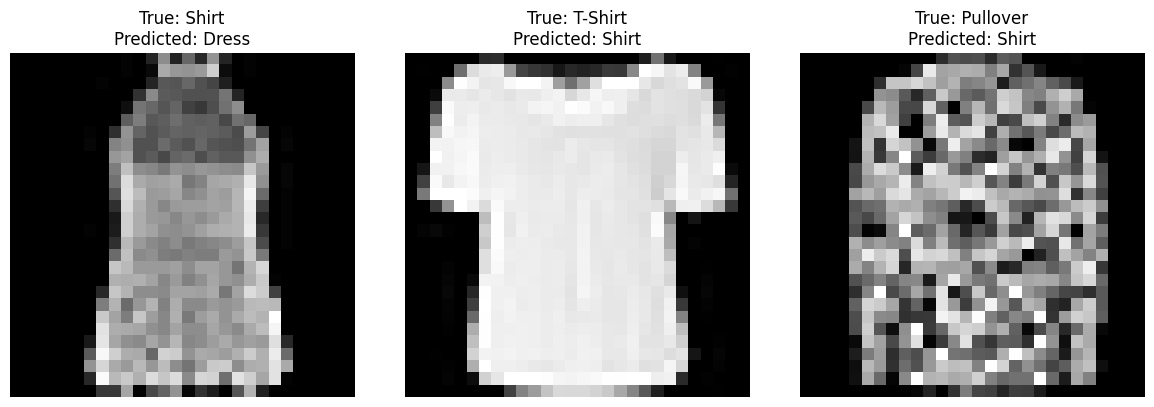

Train Accuracy: 0.9931
Test Accuracy: 0.8259


In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import random

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add numbers to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

# Function to get the predictions for a dataset
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
    return predictions, true_labels


# Get the predictions for the train and test datasets
train_predictions, train_true_labels = get_predictions(model, train_loader, device)
test_predictions, test_true_labels = get_predictions(model, test_loader, device)


# Plot the confusion matrix for the train dataset with numbers
cm_train = confusion_matrix(train_true_labels, train_predictions)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_train, classes=list(labels_map.values()), normalize=False, title='Train Confusion Matrix')
plt.show()

# Plot the confusion matrix for the test dataset with numbers
cm_test = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_test, classes=list(labels_map.values()), normalize=False, title='Test Confusion Matrix')
plt.show()

# Plot 3 random examples from the wrong predictions
wrong_predictions = [i for i, (p, t) in enumerate(zip(test_predictions, test_true_labels)) if p != t]
random_indices = random.sample(wrong_predictions, 3)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, idx in enumerate(random_indices):
    img, _ = test_data[idx]
    true_label = test_true_labels[idx]
    predicted_label = test_predictions[idx]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"True: {labels_map[true_label]}\nPredicted: {labels_map[predicted_label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
# Calculate train and test accuracy
train_accuracy = accuracy_score(train_true_labels, train_predictions)
test_accuracy = accuracy_score(test_true_labels, test_predictions)

# Print train and test accuracy
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")